In [1]:
import numpy as np
import pandas as pd

In [3]:
funding_rounds=pd.read_csv('/content/drive/MyDrive/DSL/crunchbase_1/funding_rounds.csv',index_col=0)
funding_rounds['raised_amount_usd'] = funding_rounds['raised_amount_usd'].fillna(0)

lst7=[]
for i in funding_rounds['investor_count']:
  if i== 0:
    lst7.append(np.NaN)
  else:
    lst7.append(i)

funding_rounds['investor_count'] = lst7
funding_rounds['investor_count'] = funding_rounds['investor_count'].fillna(funding_rounds['investor_count'].mean())

# 독립변수를 담을 df 생성
org = pd.DataFrame(funding_rounds['org_uuid'].unique()).rename(columns = {0 : 'org_uuid'})

# Debt Financing, Grant, Secondary Market, Convertible Note를 통해 투자받은 기록만 확인
lst0=[]
for i in funding_rounds['name']:
    lst0.append('Debt Financing' in i)

lst1=[]
for i in funding_rounds['name']:
    lst1.append('Grant' in i)

lst2=[]
for i in funding_rounds['name']:
    lst2.append('Secondary Market' in i)

lst3=[]
for i in funding_rounds['name']:
    lst3.append('Convertible Note' in i)

debt_firms = funding_rounds[lst0 or lst1 or lst2 or lst3]

# 'Debt Financing','Secondary Market','Grant','Convertible Note'를 이용해 자금을 조달한 기업이 조달한 자금 총액
debt_firms = funding_rounds[lst0 or lst1 or lst2 or lst3]
org_financing =  debt_firms[['org_uuid','raised_amount_usd']].groupby('org_uuid').sum().rename(columns = {'raised_amount_usd':'financing'})

org = pd.merge(org, org_financing, how = 'left', on = 'org_uuid').set_index('org_uuid').fillna(0)

# aver_money
funding_rounds['aver_money'] = funding_rounds['raised_amount_usd']/funding_rounds['investor_count']

aver_money = funding_rounds.groupby('org_uuid').mean()['aver_money']

org = pd.merge(org, aver_money, how = 'left', on = 'org_uuid').fillna(0)

country_match = pd.read_csv('/content/drive/MyDrive/DSL/country_match.csv',index_col = 0)

org = pd.merge(org, country_match, how = 'left', on = 'org_uuid').fillna(0)

ipo_acquisitions = pd.read_csv('/content/drive/MyDrive/DSL/by_success (1).csv',index_col=0).rename(columns = {"uuid":'org_uuid'}).set_index('org_uuid')

org = pd.merge(org,ipo_acquisitions, how='left',on='org_uuid')

org['success'] = org['is_acquisitions'] + org['is_ipos']
org['success'] = org['success'].astype(bool)

org.head()

,financing,aver_money,country_match,is_acquisitions,is_ipos,success
org_uuid,,,,,,
df662812-7f97-0b43-9d3e-12f64f504fbb,100000000.0,1.027574e+09,0.555556,0.0,1.0,True
f53cb4de-236e-0b1b-dee8-7104a8b018f9,0.0,2.260331e+06,1.000000,1.0,0.0,True
4111dc8b-c0df-2d24-ed33-30cd137b3098,0.0,4.166667e+06,1.000000,1.0,0.0,True
3d16cb4c-911e-75c0-de5a-15c316b39f98,0.0,8.020833e+05,0.000000,1.0,0.0,True
56b5f0c1-855f-2ebb-083f-16641f1db2e1,0.0,2.293750e+06,1.000000,1.0,0.0,True


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, recall_score, precision_score
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
x = org[['financing','aver_money','country_match']]
y = org['success']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

normalizer = StandardScaler()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)

model = LogisticRegression()
model.fit(x_train, y_train)

print(model.intercept_, model.coef_)
print(np.exp(model.intercept_), np.exp(model.coef_))
print(model.score(x_test, y_test))

[-1.75553895] [[-0.02131557  0.35890256  0.26160839]]
[0.17281408] [[0.97891001 1.43175729 1.29901774]]
0.8480737720535


In [8]:
feature = ['financing','aver_money','country_match']
model_coef = pd.Series(model.coef_[0], feature).sort_values(ascending = False)
model_coef = pd.DataFrame({'coefficient': model.coef_[0]}, index = feature).sort_values(by = 'coefficient', ascending = False)
model_coef

,coefficient
aver_money,0.358903
country_match,0.261608
financing,-0.021316


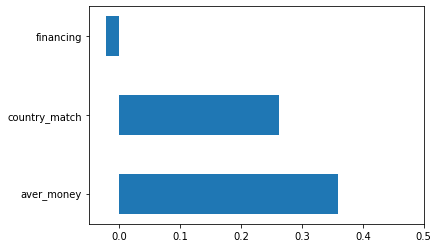

In [9]:
info = list(model_coef.index)
num = list(model_coef['coefficient'])

index = np.arange(len(info))
plt.yticks(index, info)
plt.xlim(-0.05,0.5)
plt.barh(index, num, height=0.5)
plt.show()
